In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
from ipywidgets import interact

In [79]:
# m = [7e22, 7e22, 7e22] # Array of masses
# g = 6.67384e-11 # [m^3 / (kg s^2)]

time_scale = 60.*60.*24. # We use time_scale * s as time unit
mass_scale = 1e22        # We use mass_scale * kg as mass unit
length_scale = 1e7       # We use length_scale * m as length unit

m = [ 1.0, 0.9, 1.2 ] # Array of masses in [10^20 kg]
g = mass_scale / (length_scale**3) * time_scale**2 * 6.67384e-11 # [(length_scale*m)^3 / (mass_scale*kg * (time_scale*s)^2)]
print(f'g = {g} [({length_scale}*m)^3 / ({mass_scale}*kg * ({time_scale}*s)^2)]')


N = 3
D = 3
# Coordinate system 1 unit is 10^5 m
q0 = [np.array([0.0, 0.0, 0.0]), np.array([1.2, 0.0, 0.0]), np.array([1.2, 1.2, 1.2])] # Array of vec3 (or vec2)
p0 = [np.array([0.0, 1.2, 0.0]), np.array([0.0, -1.2, 0.0]), np.array([0.0, 0.0, -0.6])] # Array of vec3 (or vec2)

g = 4.98199486464 [(10000000.0*m)^3 / (1e+22*kg * (86400.0*s)^2)]


In [66]:
def H(q, p):
    h = 0.0
    for i in range(0, N):
        h += 0.5 * np.dot(p[i], p[i]) / m[i]
        for j in range(0, i):
            h -= g * m[i] * m[j] / np.linalg.norm(q[i] - q[j])
    return h

def T(p):
    t = 0.0
    for i in range(0, N):
        t += 0.5 * np.dot(p[i], p[i]) / m[i]
    return t

def U(q):
    u = 0.0
    for i in range(0, N):
        for j in range(0, i):
            u -= g * m[i] * m[j] / np.linalg.norm(q[i] - q[j])
    return u

def dT(p):
    return [ p[i] / m[i] for i in range(N) ]

def dnU(q): # negative derivative
    result = []
    for i in range(N):
        d = np.zeros((D,))
        for j in range(N):
            if i != j:
                d -= (q[i] - q[j]) * g * m[i] * m[j] / np.linalg.norm(q[i] - q[j])**3
        result.append(d)
    return result

def dnU_(q):
    result = [ np.array([0.0] * D) for i in range(N) ]
    for i in range(N):
        for j in range(i):
            force = (q[j] - q[i]) * g * m[i] * m[j] / np.linalg.norm(q[i] - q[j])**3
            result[i] += force
            result[j] -= force
    return result

def unpack_y(y):
    q = [ y[i:i+D] for i in range(0, D*N, D)]
    p = [ y[i:i+D] for i in range(D*N, 2*D*N, D)]

    return q, p

def pack_y(q, p):
    return np.concat((np.concat(q), np.concat(p)))

def f(y):
    q, p = unpack_y(y)
    return pack_y(dT(p), dnU_(q))


assert np.abs(T(p0) + U(q0) - H(q0, p0)) < 1e-14

assert len(dT(p0)) == N
#assert np.all(np.array(dT(p0)) == np.array(p0))
assert len(dnU(q0)) == N
assert len(dnU_(q0)) == N


assert np.all(pack_y(*unpack_y(np.array([1., 2., 3., 4., 5., 6., 7., 8.]))) == np.array([1., 2., 3., 4., 5., 6., 7., 8.]))


In [67]:
def solve_symplectic_euler(dT, dnU, num_steps, t_end, q0, p0):
    tau = t_end / num_steps
    qs, ps = [q0], [p0]
    q, p = q0, p0
    for i in range(num_steps):
        p = [ pk + tau * dnUqk for (pk, dnUqk) in zip(p, dnU(q)) ]
        q = [ qk + tau * dTpk for (qk, dTpk) in zip(q, dT(p)) ]
        qs.append(q)
        ps.append(p)
    return qs, ps

def solve_symplectic_euler_2(dT, dnU, num_steps, t_end, q0, p0):
    tau = t_end / num_steps
    qs, ps = [q0], [p0]
    q, p = q0, p0
    for i in range(num_steps):
        q = [ qk + tau * dTpk for (qk, dTpk) in zip(q, dT(p)) ]
        p = [ pk + tau * dnUqk for (pk, dnUqk) in zip(p, dnU(q)) ]
        qs.append(q)
        ps.append(p)
    return qs, ps

# From 'Geometric Numerical Integration (Hairer, p. 190)'
def solve_leapfrog(dT, dnU, num_steps, t_end, q0, p0):
    tau = t_end / num_steps
    q0_, p0_ = np.array(q0), np.array(p0)
    qs, ps = [q0_], [p0_]
    q, p = q0_, p0_
    for i in range(num_steps):
        p = p + (tau / 2.0) * np.array(dnU(q))
        q = q + tau * np.array(dT(p))
        p = p + (tau / 2.0) * np.array(dnU(q))
        qs.append(q)
        ps.append(p)
    return qs, ps


In [77]:
def rescale(x, interval_in, interval_out):
    a, b = interval_in
    c, d = interval_out
    return c + (x - a) * (d - c) / (b - a)

def plot(qs, ps, n, title=''):
    fig, ax = plt.subplots(figsize=(7, 6), subplot_kw=dict(projection="3d"))

    # Compute sizes
    min_mass, max_mass = min(m), max(m)
    min_size, max_size = 50.0, 300.0
    s = [ rescale(mass, (min_mass, max_mass), (min_size, max_size)) for mass in m  ] if min_mass < max_mass else [min_size] * len(m)

    # Final position
    q, p = qs[n], ps[n]

    for i in range(N):
        point = ax.scatter(q[i][0], q[i][1], q[i][2], s=s[i], label=f'$m_{i+1}$')
        arrow_length = np.linalg.norm(p[i])
        ax.quiver(
            q[i][0], q[i][1], q[i][2],
            p[i][0], p[i][1], p[i][2],
            length=arrow_length,
            normalize=False,
            arrow_length_ratio=0.02,
            color=point.get_facecolor()
        )

        xs = [qs[j][i][0] for j in range(n+1)]
        ys = [qs[j][i][1] for j in range(n+1)]
        zs = [qs[j][i][2] for j in range(n+1)]
        ax.plot(xs, ys, zs, alpha=0.6, color = point.get_facecolor())

    # Force same limits for x and y to make the plot square
    Q = np.array(qs)
    P = np.array(ps)
    min_x = np.min(Q[:, :, 0]) # min(np.min(Q[:, :, 0]), np.min(Q[:, :, 0] + P[:, :, 0]))
    max_x = np.max(Q[:, :, 0]) # max(np.max(Q[:, :, 0]), np.max(Q[:, :, 0] + P[:, :, 0]))
    min_y = np.min(Q[:, :, 1]) # min(np.min(Q[:, :, 1]), np.min(Q[:, :, 1] + P[:, :, 1]))
    max_y = np.max(Q[:, :, 1]) # max(np.max(Q[:, :, 1]), np.max(Q[:, :, 1] + P[:, :, 1]))
    min_x = np.min(Q[:, :, 0]) # min(np.min(Q[:, :, 0]), np.min(Q[:, :, 0] + P[:, :, 0]))
    max_x = np.max(Q[:, :, 0]) # max(np.max(Q[:, :, 0]), np.max(Q[:, :, 0] + P[:, :, 0]))
    min_z = np.min(Q[:, :, 2]) # min(np.min(Q[:, :, 2]), np.min(Q[:, :, 2] + P[:, :, 2]))
    max_z = np.max(Q[:, :, 2]) # max(np.max(Q[:, :, 2]), np.max(Q[:, :, 2] + P[:, :, 2]))
    min_lim = 1.25*min(min_x, min_y, min_z)
    max_lim = 1.25*max(max_x, max_y, max_z)
    ax.set_xlim(min_lim, max_lim)
    ax.set_ylim(min_lim, max_lim)
    ax.set_zlim(min_lim, max_lim)

    ax.set_xlabel(f'$x\\ [{length_scale}m]$')
    ax.set_ylabel(f'$y\\ [{length_scale}m]$')
    ax.set_zlabel(f'$z\\ [{length_scale}m]$')

    ax.set_title(title)
    ax.legend()
    fig.tight_layout()
    fig.show()

In [78]:
t_span = (0.0, 2.0)
y0 = pack_y(q0, p0)
sol = scipy.integrate.solve_ivp(lambda t, y: f(y), t_span = t_span, y0 = y0, t_eval=np.linspace(*t_span, num=501), atol=1e-12, rtol=1e-12)

qs, ps = list(zip(*[ unpack_y(sol.y[:, j]) for j in range(sol.y.shape[1]) ]))

@interact(i=(0, len(sol.t)-1))
def update(i=len(sol.t)-1):
    plot(qs, ps, i, f'Reference Solution $t = {sol.t[i]}\\ [{time_scale}s]$')

interactive(children=(IntSlider(value=500, description='i', max=500), Output()), _dom_classes=('widget-interac…

In [ ]:
num_steps = 30000
qs_, ps_ = solve_symplectic_euler_2(dT, dnU_, num_steps, t_span[1], q0, p0)

@interact(i=(0, num_steps))
def update2(i=num_steps):
    plot(qs_, ps_, i, f'Symplectic Euler (2) $t = {i * t_span[1] / num_steps}\\ [{time_scale}s]$')

interactive(children=(IntSlider(value=0, description='i', max=30000), Output()), _dom_classes=('widget-interac…

In [ ]:
num_steps_leapfrog = 40000
qs_, ps_ = solve_leapfrog(dT, dnU_, num_steps_leapfrog, t_span[1], q0, p0)

@interact(i=(0, num_steps_leapfrog))
def update3(i=num_steps_leapfrog):
    plot(qs_, ps_, i, f'Leapfrog $t = {i * t_span[1] / num_steps_leapfrog}\\ [{time_scale}s]$')

interactive(children=(IntSlider(value=40000, description='i', max=40000), Output()), _dom_classes=('widget-int…

Done with Leapfrog
Done with Symplectic Euler


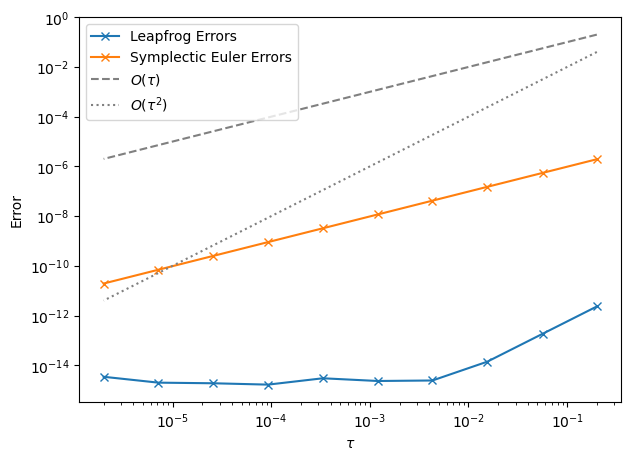

In [190]:
def convergence_plot():
    t_end = 2.0
    n = np.geomspace(1e1, 1e6, num = 10, dtype=int)
    tau = t_end / n

    ref_sol = scipy.integrate.solve_ivp(lambda t, y: f(y), t_span = (0.0, t_end), y0 = y0, dense_output = True, atol=1e-12, rtol=1e-12)
    ref_sol_q = lambda t: np.array(unpack_y(ref_sol.sol(t))[0])

    leapfrog_sols = [ solve_leapfrog(dT, dnU_, num_steps, t_end, q0, p0) for num_steps in n ]
    print("Done with Leapfrog")
    symplectic_euler_sols = [ solve_symplectic_euler(dT, dnU_, num_steps, t_end, q0, p0) for num_steps in n ]
    print("Done with Symplectic Euler")

    leapfrog_errors = [ max([ np.max(np.abs(leapfrog_sols[k][0][i] - ref_sol_q(i * t_end / num_steps))) for i in range(num_steps+1) ]) for (k, num_steps) in enumerate(n) ]
    symplectic_euler_errors = [ max([ np.max(np.abs(symplectic_euler_sols[k][0][i] - ref_sol_q(i * t_end / num_steps))) for i in range(num_steps+1) ]) for (k, num_steps) in enumerate(n) ]


    fig, ax = plt.subplots(figsize=(7, 5))

    ax.plot(tau, leapfrog_errors, marker='x', label='Leapfrog Errors')
    ax.plot(tau, symplectic_euler_errors, marker='x', label='Symplectic Euler Errors')
    ax.plot(tau, tau**1, color='gray', linestyle='dashed', label='$O(\\tau)$')
    ax.plot(tau, tau**2, color='gray', linestyle='dotted', label='$O(\\tau^2)$')

    ax.set_xlabel('$\\tau$')
    ax.set_ylabel('Error')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()

    fig.show()

convergence_plot()

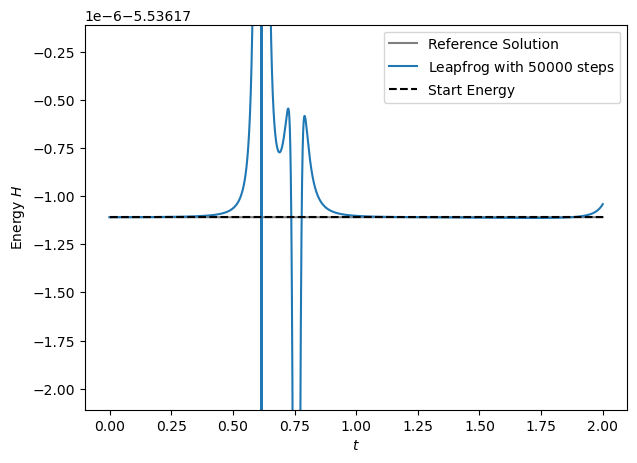

In [ ]:
def energy_plot():
    t_end = 2.0
    leapfrog_ns = [ 50000 ]
    symplectic_euler_ns = [  ]

    ref_sol = scipy.integrate.solve_ivp(lambda t, y: f(y), t_span = (0.0, t_end), y0 = y0, t_eval=np.linspace(0.0, 2.0, num=500), atol=1e-12, rtol=1e-12)
    qs, ps = list(zip(*[ unpack_y(ref_sol.y[:, j]) for j in range(ref_sol.y.shape[1]) ]))
    ref_energies = [ H(q, p) for (q, p) in zip(qs, ps) ]

    leapfrog_energies = []
    for n in leapfrog_ns:
        qs, ps = solve_leapfrog(dT, dnU_, n, t_end, q0, p0)
        leapfrog_energies.append([ H(q, p) for (q, p) in zip(qs, ps) ])

    symplectic_euler_energies = []
    for n in symplectic_euler_ns:
        qs, ps = solve_symplectic_euler(dT, dnU_, n, t_end, q0, p0)
        symplectic_euler_energies.append([ H(q, p) for (q, p) in zip(qs, ps) ])

    
    fig, ax = plt.subplots(figsize=(7, 5))
    
    ax.plot(ref_sol.t, ref_energies, color='gray', label='Reference Solution')
    for (k, n) in enumerate(leapfrog_ns):
        ax.plot(np.linspace(0.0, t_end, num=n+1), leapfrog_energies[k], label=f'Leapfrog with ${n}$ steps')
    for (k, n) in enumerate(symplectic_euler_ns):
        ax.plot(np.linspace(0.0, t_end, num=n+1), symplectic_euler_energies[k], label=f'Symplectic Euler with ${n}$ steps')
    ax.plot([0.0, t_end], [H(q0, p0)] * 2, color='black', linestyle='dashed', label='Start Energy')

    ax.set_ylim(H(q0, p0) - 1e-6, H(q0, p0) + 1e-6)
    ax.set_xlabel('$t$')
    ax.set_ylabel('Energy $H$')
    ax.legend()

    fig.show()

energy_plot()